# STUDY CASE - Fraudulent Activity

--- OBJECTIF ---

Les sites E-commerce font transiter beaucoup d'argent. Cela peut engendrer des risques non négligeables d'activités frauduleuses comme l'utilisation de carte de crédit volées, du blanchiment d'argent etc.

Fort heureusement, le Machine Learning peut nous aider à identifier ces activités frauduleuses. Tous les sites web où vous devez entrer vos informations de paiements ont une équipe qui s'occupe de gérer les risques de fraude via le ML.

Le but de ce challenge est de construire un modèle qui vous permette de prédire une probabilité de transaction frauduleuse.


--- DESCRIPTION ---

L'entreprise X fait du E-commerce et vend des vêtements faits-main. Votre but est de construire un modèle qui permette de prédire si l'achat d'un vêtement doit être considérée comme une transaction frauduleuse ou non.

Voici précisément ce que vous devez faire :

1. Pour chacun des utilisateurs, déterminez le pays d'origine depuis son adresse IP

2. Construisez un modèle qui permette de prédire si l'activité est frauduleuse ou non. Expliquez aussi vos choix / hypothèses en termes d'optimisation de faux-positifs et faux-négatifs

3. Votre patron aimerait comprendre votre modèle car elle est inquiète d'utiliser un modèle _black box_. Comment l'expliqueriez vous d'un point utilisateur, et non pas mathématiques. Par exemples, quels sont les utilisateurs qui peuvent être classés comme _risqués_ ?

4. Disons que vous pouvez utiliser votre modèle en live pour qu'il fasse sa prédiction en temps réel. D'un point de vu Produit, comment vous l'utiliseriez ? Comment pourriez vous pensez l'expérience utilisateur fasse à ce produit ?


--- DATA ---

Vous avez deux tables que vous pourrez utiliser :
 - Fraud_Data
 - IpAddress_to_Country

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu(first_level=1, last_level=4, header="SOMMAIRE")

# I. LIBRARIES & FUNCTIONS

## Libraries

In [66]:
# Basic Librairies :
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import datetime as dt

# Sklearn :
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, confusion_matrix, precision_score

## Functions

In [3]:
def find_country(x):
    """
    Return the name of the country depending on the IP Address used during transaction.
    the argument is an IP Address
    """
        
    try :
        return Countries[(Countries.lower_bound_ip_address > x) & (Countries.upper_bound_ip_address > x)].country.iloc[0]
    except :
        return 'Unknown'
    
    
    
def num_cat_index(X) :
    """
    Function to differentiate numerical from categorical columns.
    Return 2 lists : 
       - num_index : numerical column index
       - cat_index : categorical column index
    """
    
    idx = 0
    num_features = []
    num_index = []
    cat_features = []
    cat_index = []
    
    for col, col_type in X.dtypes.iteritems() :
        if  ('float' in str(col_type)) or ('int' in str(col_type)) :
            num_features.append(col)
            num_index.append(idx)
        else :
            cat_features.append(col)
            cat_index.append(idx)
        idx = idx + 1

    print('Numeric features :', num_features,"\nNumeric features' index :", num_index)
    print('Categorical features :', cat_features,"\nCategorical features' index :", cat_index)    
    return num_index, cat_index

# II. DATASETS

## Loading

In [4]:
Transactions = pd.read_csv("Datasets/Fraud_Data.csv")
Countries = pd.read_csv("Datasets/IpAddress_to_Country.csv")
print("Transactions dataset shape :", Transactions.shape)
print("Countries dataset shape :", Countries.shape)

Transactions dataset shape : (151112, 11)
Countries dataset shape : (138846, 3)


## Quick Exploration

### Transactions Dataset

In [5]:
Transactions.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [6]:
Transactions.describe(include = 'all')

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
count,151112.000000,151112,151112,151112.000000,151112,151112,151112,151112,151112.000000,1.511120e+05,151112.000000
unique,NaN,151112,150679,NaN,137956,3,5,2,NaN,NaN,NaN
top,NaN,2015-05-04 06:08:58,2015-06-08 09:42:04,NaN,NGQCKIADMZORL,SEO,Chrome,M,NaN,NaN,NaN
freq,NaN,1,3,NaN,20,60615,61432,88293,NaN,NaN,NaN
mean,200171.040970,NaN,NaN,36.935372,NaN,NaN,NaN,NaN,33.140704,2.152145e+09,0.093646
std,115369.285024,NaN,NaN,18.322762,NaN,NaN,NaN,NaN,8.617733,1.248497e+09,0.291336
min,2.000000,NaN,NaN,9.000000,NaN,NaN,NaN,NaN,18.000000,5.209350e+04,0.000000
25%,100642.500000,NaN,NaN,22.000000,NaN,NaN,NaN,NaN,27.000000,1.085934e+09,0.000000
50%,199958.000000,NaN,NaN,35.000000,NaN,NaN,NaN,NaN,33.000000,2.154770e+09,0.000000
75%,300054.000000,NaN,NaN,49.000000,NaN,NaN,NaN,NaN,39.000000,3.243258e+09,0.000000


In [7]:
print("nombre d'opération répertoriées : {}".format(Transactions['class'].count()))
print("nombre d'opération indiqué comme fraude : {}".format(Transactions['class'].sum()))
print("Fréquence des fraudes : {}%".format(round(100*Transactions['class'].sum()/Transactions['class'].count(),2)))

nombre d'opération répertoriées : 151112
nombre d'opération indiqué comme fraude : 14151
Fréquence des fraudes : 9.36%


### Countries - IP Address Dataset

In [70]:
Countries.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


In [71]:
Countries.describe(include = 'all')

,lower_bound_ip_address,upper_bound_ip_address,country
count,1.388460e+05,1.388460e+05,138846
unique,NaN,NaN,235
top,NaN,NaN,United States
freq,NaN,NaN,46868
mean,2.724532e+09,2.724557e+09,NaN
std,8.975215e+08,8.974979e+08,NaN
min,1.677722e+07,1.677747e+07,NaN
25%,1.919930e+09,1.920008e+09,NaN
50%,3.230887e+09,3.230888e+09,NaN
75%,3.350465e+09,3.350466e+09,NaN


## Joining datasets

In [8]:
Transactions['country'] = Transactions.ip_address.apply(find_country)

In [9]:
Transactions.head(3)

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States


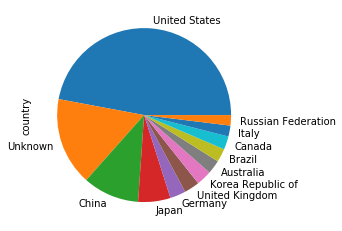

In [72]:
Transactions.country.value_counts()[Transactions.country.value_counts() >2000].plot(kind="pie")

## Comments

- Le nombre d'opération répertoriées est de 151 112,
- Le nombre d'opération indiquée comme fraude est de 14 151,
- La fréquence des fraudes est de 9.36%


- La majorité des transations frauduleuses ont été réalisées aux USA.
- Le pays de nombreuses transactions frauduleuses n'est pas identifié (à partir des informations de l'adresse IP dont nous disposons)

## Saving / Loading joined dataset

In [11]:
# Saving joined dataset (.csv format) :
name = 'joined_transactions'
Transactions.to_csv("{}.csv".format(name), index=False)

In [12]:
# Loading joined dataset :
name = 'joined_transactions'
Transactions = pd.read_csv("{}.csv".format(name))

print("Loaded dataset shape :", Transactions.shape)

Loaded dataset shape : (151112, 12)


# III. FEATURES ENGINEERING

## Copying dataset

In [13]:
dataset = Transactions.copy(deep=True)

## Column type

In [14]:
dataset.dtypes

user_id             int64
signup_time        object
purchase_time      object
purchase_value      int64
device_id          object
source             object
browser            object
sex                object
age                 int64
ip_address        float64
class               int64
country            object
dtype: object

In [15]:
# Converting 'signup_time' and 'purchase_time' into datetime format :

dataset['signup_time'] = dataset.signup_time.apply(lambda x : dt.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
dataset['purchase_time'] = dataset.purchase_time.apply(lambda x : dt.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))

## Column creation : 'Transaction_delay'

In [16]:
# Creating 'Transaction_delay' column, in seconds :

dataset['transaction_delay'] = [x.total_seconds() for x in (dataset['purchase_time'] - dataset['signup_time'])]

## Column creation : 'device_using' 

In [17]:
# 'device_using' correspond to the number of time a device has been used to make a transaction.

Device_count = pd.DataFrame(dataset['device_id'].value_counts())

dataset['device_using'] = [Device_count.loc[x][0] for x in dataset['device_id']]

## Columns creation : 'signup_time' extraction / 'purchase_time' extraction

In [18]:
# 'signup_time' extraction :
dataset['signup_year'] = pd.DatetimeIndex(dataset['signup_time']).year
dataset['signup_month'] = pd.DatetimeIndex(dataset['signup_time']).month
dataset['signup_day'] = pd.DatetimeIndex(dataset['signup_time']).day
dataset['signup_hour'] = pd.DatetimeIndex(dataset['signup_time']).hour
dataset['signup_second'] = pd.DatetimeIndex(dataset['signup_time']).second

# 'purchase_time' extraction :
dataset['purchase_year'] = pd.DatetimeIndex(dataset['purchase_time']).year
dataset['purchase_month'] = pd.DatetimeIndex(dataset['purchase_time']).month
dataset['purchase_day'] = pd.DatetimeIndex(dataset['purchase_time']).day
dataset['purchase_hour'] = pd.DatetimeIndex(dataset['purchase_time']).hour
dataset['purchase_second'] = pd.DatetimeIndex(dataset['purchase_time']).second

## Comments

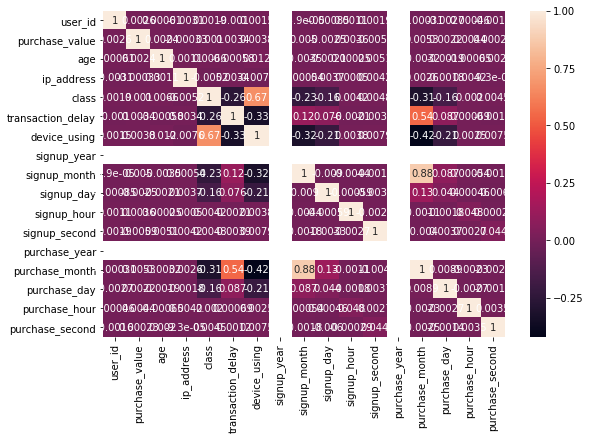

In [19]:
# Correlation matrix :
corr = dataset.corr()
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(corr, annot=True, ax=ax)

On constate que les paramètres suivants sont les plus corrélés à la fraude :
- 'transaction_delay'
- 'device_using'
- 'signup_month'
- 'signup_day'
- 'purchase_month'
- 'purchase_day'

D'autre part, 'signup_year' and 'purchase_year' sont inutiles car constantes.

## 'transaction_delay'

In [20]:
dataset[dataset['transaction_delay']<5].describe()

,user_id,purchase_value,age,ip_address,class,transaction_delay,device_using,signup_year,signup_month,signup_day,signup_hour,signup_second,purchase_year,purchase_month,purchase_day,purchase_hour,purchase_second
count,7600.000000,7600.000000,7600.000000,7.600000e+03,7600.0,7600.0,7600.000000,7600.0,7600.0,7600.000000,7600.000000,7600.000000,7600.0,7600.0,7600.000000,7600.000000,7600.000000
mean,200606.270263,36.956711,33.576053,2.132135e+09,1.0,1.0,12.052500,2015.0,1.0,6.639342,11.677500,29.911053,2015.0,1.0,6.639342,11.677632,29.987368
std,116621.065917,18.398925,8.594367,1.209606e+09,0.0,0.0,3.118404,0.0,0.0,3.508350,6.735412,17.158205,0.0,0.0,3.508350,6.735370,17.182373
min,39.000000,9.000000,18.000000,2.278096e+06,1.0,1.0,2.000000,2015.0,1.0,1.000000,0.000000,0.000000,2015.0,1.0,1.000000,0.000000,0.000000
25%,97693.250000,22.000000,28.000000,1.120301e+09,1.0,1.0,10.000000,2015.0,1.0,4.000000,6.000000,15.000000,2015.0,1.0,4.000000,6.000000,15.000000
50%,199842.500000,35.000000,33.000000,2.147483e+09,1.0,1.0,12.000000,2015.0,1.0,7.000000,12.000000,30.000000,2015.0,1.0,7.000000,12.000000,30.000000
75%,303315.000000,49.000000,39.000000,3.182244e+09,1.0,1.0,14.000000,2015.0,1.0,10.000000,17.000000,45.000000,2015.0,1.0,10.000000,17.000000,45.000000
max,399974.000000,100.000000,63.000000,4.292714e+09,1.0,1.0,20.000000,2015.0,1.0,13.000000,23.000000,59.000000,2015.0,1.0,13.000000,23.000000,59.000000


On constate que le délai de la transaction nous permet d'identifier 7 600 cas de fraude sur 14 151, soit 54%.

## Droping useless column

In [21]:
useless_col = ['user_id', 'signup_time', 'purchase_time', 'device_id', 'ip_address', 'signup_year', 'purchase_year']

dataset = dataset.drop(columns=useless_col)

In [22]:
dataset.head(3)

,purchase_value,source,browser,sex,age,class,country,transaction_delay,device_using,signup_month,signup_day,signup_hour,signup_second,purchase_month,purchase_day,purchase_hour,purchase_second
0,34,SEO,Chrome,M,39,0,Japan,4506682.0,1,2,24,22,49,4,18,2,11
1,16,Ads,Chrome,F,53,0,United States,17944.0,1,6,7,20,50,6,8,1,54
2,15,SEO,Opera,M,53,1,United States,1.0,12,1,1,18,44,1,1,18,45


# IV. FEATURES SELECTION

## Features selection

In [23]:
dataset.columns

Index(['purchase_value', 'source', 'browser', 'sex', 'age', 'class', 'country',
       'transaction_delay', 'device_using', 'signup_month', 'signup_day',
       'signup_hour', 'signup_second', 'purchase_month', 'purchase_day',
       'purchase_hour', 'purchase_second'],
      dtype='object')

In [24]:
# At first, we select all columns :
features_list = dataset.columns.drop('class')

## Variables definition

In [51]:
X = dataset[features_list]
y = dataset['class']

In [49]:
# Séparation des variables explicatives de type numérique et catégorique :
num_index, cat_index = num_cat_index(dataset[features_list])

Numeric features : ['purchase_value', 'age', 'transaction_delay', 'device_using', 'signup_month', 'signup_day', 'signup_hour', 'signup_second', 'purchase_month', 'purchase_day', 'purchase_hour', 'purchase_second'] 
Numeric features' index : [0, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Categorical features : ['source', 'browser', 'sex', 'country'] 
Categorical features' index : [1, 2, 3, 5]


# V. PREDICTION MODEL

## Encoding & Standardizing features

Encoding to be done before train_test_split, 
otherwise some country in test set might not have OneHotEncoding values

In [52]:
# Converting Pandas DataFrame into Numpy Arrays before using Scikit-Learn :
print("Convert pandas DataFrames to numpy arrays...")
X = X.values
y = y.values
print("...Done")

Convert pandas DataFrames to numpy arrays...
...Done


In [53]:
# Encoding categorical features and standardizing numerical features :
print("Encoding categorical features and standardizing numerical features on train set...\n")
print(X[0:3,:])

# Standardizing :
numeric_transformer = StandardScaler()

# OneHotEncoding :
categorical_transformer = OneHotEncoder(drop='first')

# Encoder :
featureencoder = ColumnTransformer(transformers=[
    ('cat', categorical_transformer, cat_index),    
    ('num', numeric_transformer, num_index)])

X = featureencoder.fit_transform(X)
print("...Done")
print(X[0:3,:])

Encoding categorical features and standardizing numerical features on train set...

[[34 'SEO' 'Chrome' 'M' 39 'Japan' 4506682.0 1 2 24 22 49 4 18 2 11]
 [16 'Ads' 'Chrome' 'F' 53 'United States' 17944.0 1 6 7 20 50 6 8 1 54]
 [15 'SEO' 'Opera' 'M' 53 'United States' 1.0 12 1 1 18 44 1 1 18 45]]
...Done
  (0, 1)	1.0
  (0, 6)	1.0
  (0, 85)	1.0
  (0, 188)	-0.16020412903850612
  (0, 189)	0.6799137858473908
  (0, 190)	-0.1360565761441386
  (0, 191)	-0.2615135500539275
  (0, 192)	-0.9515417563660264
  (0, 193)	1.0616300174506512
  (0, 194)	1.5195567053220365
  (0, 195)	1.1299238676082992
  (0, 196)	-0.754945668859095
  (0, 197)	0.30876759508418966
  (0, 198)	-1.3774553328047157
  (0, 199)	-1.0697229799601764
  (1, 177)	1.0
  (1, 188)	-1.142592014266996
  (1, 189)	2.304476246286727
  (1, 190)	-1.5718771332640944
  (1, 191)	-0.2615135500539275
  (1, 192)	0.8207530343661219
  (1, 193)	-0.8854870300509678
  (1, 194)	1.230381598492196
  (1, 195)	1.187810768578327
  (1, 196)	-0.003243355315464203

## Train set / Test set definition

In [54]:
print("Dividing into train and test sets...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0, stratify=y)
print("...Done.")
print()

Dividing into train and test sets...
...Done.



## Pipeline

### Model selection : RandomForestClassifier

In [55]:
RFC = RandomForestClassifier(class_weight='balanced')

### Model training

In [56]:
print("Train model...")
RFC.fit(X_train, y_train)
print("...Done.")

Train model...
...Done.


### Prediction on training set

In [57]:
print("Predictions on training set...")
y_train_pred = RFC.predict(X_train)
print("...Done.")

Predictions on training set...
...Done.


### Prediction on test set

In [58]:
print("Predictions on test set...")
y_test_pred = RFC.predict(X_test)
print("...Done.")

Predictions on test set...
...Done.


## Performance assessment

### F1-Score

In [61]:
# f1-score :
print("f1-score on train set : ", f1_score(y_train, y_train_pred))
print("f1-score on test set : ", f1_score(y_test, y_test_pred))

f1-score on train set :  0.999528672427337
f1-score on test set :  0.7101185050136736


### Confusion matrix

In [62]:
print("Confusion matrix on train set : ")
print(confusion_matrix(y_train, y_train_pred))
print()
print("Confusion matrix on test set : ")
print(confusion_matrix(y_test, y_test_pred))

Confusion matrix on train set : 
[[123264      0]
 [    12  12724]]

Confusion matrix on test set : 
[[13697     0]
 [  636   779]]


## Comments

- On constate que l'ensemble des fraudes sont détectées.


- Le F1-Score diminue de manière importante pour le Test Set, cependant en regardant la matrice de confusion on constate que l'augmentation des erreurs n'est constaté que sur les FP (Faux-Positif = transaction non-frauduleuse jugée par le modèle comme frauduleuse), ce qui est peu impactant pour notre modèle où nous recherchons surtout à trouver toutes les fraudes. Ceci peut être vu directement en considérant le precision-score (cf. ci-dessous).


- Dans le cas des transaction prédits comme frauduleuse, un système de double vérification pourra être mis en oeuvre pour valider que la transaction n'est pas fauduleuse, ce qui permettra de traiter les FP.

In [69]:
# Precision-score :
print("precision-score on train set : ", precision_score(y_train, y_train_pred))
print("precision-score on test set : ", precision_score(y_test, y_test_pred))

precision-score on train set :  1.0
precision-score on test set :  1.0
